In [1]:
import plotly.graph_objects as go
import urllib, json
import os
os.getcwd()

'/lambda_stor/homes/ac.tfeng/git/DrugCell'

In [2]:
# import anndata
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.distributions import MultivariateNormal

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="4"

import copy

import tqdm

from codes.utils.util import *
from codes.drugcell_NN import *

if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

/homes/ac.tfeng/miniconda3/envs/general/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import plotly
import plotly.express as px
import plotly.io as pio

from captum.attr import LayerIntegratedGradients
from collections import defaultdict


In [4]:
!nvidia-smi

Mon Jan 15 11:14:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:1A:00.0 Off |                    0 |
| N/A   24C    P0              40W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
DEVICE = 'cuda:6'

# GO Term

In [6]:
import goatools
from os.path import exists
from goatools.obo_parser import GODag

if not exists('go-basic.obo'):
    !wget http://geneontology.org/ontology/go-basic.obo
go_dag = GODag('go-basic.obo', optional_attrs=['def'])

go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms; optional_attrs(def)


In [7]:
go_dag['GO:0008150'].name

'biological_process'

# TCGA

### Data loading

In [8]:
training_file = "data/drugcell_train.txt"
testing_file = "data/drugcell_test.txt"
val_file = "data/drugcell_val.txt"
cell2id_file = "data/cell2ind.txt"
drug2id_file = "data/drug2ind.txt"
genotype_file = "data/cell2mutation.txt"
fingerprint_file = "data/drug2fingerprint.txt"
onto_file = "data/drugcell_ont.txt"
gene2id_file = "data/gene2ind.txt"

train_data, feature_dict, cell2id_mapping, drug2id_mapping = prepare_train_data(training_file, 
                                                                  testing_file, cell2id_file, 
                                                                  drug2id_file)

gene2id_mapping = load_mapping(gene2id_file)

# load cell/drug features
cell_features = np.genfromtxt(genotype_file, delimiter=',')
drug_features = np.genfromtxt(fingerprint_file, delimiter=',')

num_cells = len(cell2id_mapping)
num_drugs = len(drug2id_mapping)
num_genes = len(gene2id_mapping)
drug_dim = len(drug_features[0,:])

# load ontology
dG, root, term_size_map, \
    term_direct_gene_map = load_ontology(onto_file, 
                                         gene2id_mapping)

Total number of cell lines = 1225
Total number of drugs = 684
There are 3008 genes
There are 1 roots: GO:0008150
There are 2086 terms
There are 1 connected componenets


In [9]:
class RNASeqData(Dataset):
    
    def __init__(self, X, c=None, y=None, transform=None):
        self.X = X
        self.y = y
        self.c = c
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        if self.y is not None and self.c is None:
            return sample, self.y[index]
        elif self.y is not None and self.c is not None:
            return sample, self.y[index], self.c[index]
        elif self.y is None and self.c is not None:
            return sample, self.c[index]
        else:
            return sample

In [10]:
## expression and IHC data

rna_seq = pd.read_csv('data/tcga/train_tcga_expression_matrix_processed.tsv',sep='\t',index_col=0)
tcga_mad_genes = pd.read_csv('data/tcga/tcga_mad_genes.tsv', sep='\t')
tcga_sample_counts = pd.read_csv('data/tcga/tcga_sample_counts.tsv', sep='\t')
tcga_sample_identifiers = pd.read_csv('data/tcga/tcga_sample_identifiers.tsv', sep='\t',index_col=0)

# rna_seq = rna_seq.loc[:,tcga_mad_genes.gene_id[:3000].apply(str)]
rna_seq = rna_seq / rna_seq.std()
rna_seq = np.log(rna_seq + 1)

In [11]:
tcga_df = rna_seq
gene_id_dict = pd.read_csv('data/tcga/gene_dict.csv')

new_column = []
for col_name in tcga_df.columns:
    col_loc = (gene_id_dict.entrezgene_id == int(col_name))
    if np.sum(col_loc) == 0:
        tcga_df = tcga_df.drop(columns = col_name)
    else:
        new_column.append(gene_id_dict.hgnc_symbol[gene_id_dict.entrezgene_id == int(col_name)].iloc[0])
        

tcga_df.columns = new_column

In [12]:
tcga_df.columns = new_column

#### Create gene2ID for tcga

In [13]:
tcga_gene2id = {}
for idx, gene in enumerate(tcga_df.columns):
    tcga_gene2id[gene] = idx

#### Align gene id with tcga

In [14]:
gene_intersect_list = list(set(gene2id_mapping.keys()) & set(tcga_df.columns))
tcga_tensor = torch.zeros(tcga_df.shape[0], num_genes)

for gene in gene_intersect_list:
    idx = gene2id_mapping[gene]
    tcga_tensor[:,idx] = torch.tensor(tcga_df[gene])

In [15]:
cancer_2_idx = {}
idx_2_cancer = {}
cancer_type_idx = []
cancer_type = tcga_sample_identifiers.loc[tcga_df.index, 'cancer_type']

i = 0
for cancer in cancer_type:
    if cancer not in cancer_2_idx:
        cancer_2_idx[cancer] = i
        idx_2_cancer[i] = cancer
        cancer_type_idx.append(i)
        
        i += 1
    else:
        cancer_type_idx.append(cancer_2_idx[cancer])

y = torch.tensor(cancer_type_idx)

In [16]:
torch.manual_seed(0)

tcga_dataset = RNASeqData(X = tcga_tensor, y = y)
training_set, testing_set = random_split(tcga_dataset, [0.7, 0.3])

In [17]:
class dcell_vae(nn.Module):

    def __init__(self, term_size_map, term_direct_gene_map, dG, ngene, root, 
                 num_hiddens_genotype, num_hiddens_final, n_class, inter_loss_penalty = 0.2):

        super(dcell_vae, self).__init__()

        self.root = root
        self.num_hiddens_genotype = num_hiddens_genotype
        self.num_hiddens_final = num_hiddens_final
        self.n_class = n_class
        self.inter_loss_penalty = inter_loss_penalty
        self.dG = copy.deepcopy(dG)

        # dictionary from terms to genes directly annotated with the term
        self.term_direct_gene_map = term_direct_gene_map

        self.term_visit_count = {}
        self.init_term_visits(term_size_map)
        
        # calculate the number of values in a state (term): term_size_map is the number of all genes annotated with the term
        self.term_dim_map = {}
        self.cal_term_dim(term_size_map)

        # ngenes, gene_dim are the number of all genes
        self.gene_dim = ngene

        # add modules for neural networks to process genotypes
        self.contruct_direct_gene_layer()
        self.construct_NN_graph(self.dG)

        # add modules for final layer TODO: modify it into VAE
        final_input_size = num_hiddens_genotype # + num_hiddens_drug[-1]
        self.add_module('final_linear_layer', nn.Linear(final_input_size, num_hiddens_final * 2))
        self.add_module('final_batchnorm_layer', nn.BatchNorm1d(num_hiddens_final * 2))
        self.add_module('final_aux_linear_layer', nn.Linear(num_hiddens_final * 2, 1))
        self.add_module('final_linear_layer_output', nn.Linear(1, 1))
        
        self.decoder_affine = nn.Linear(num_hiddens_final, n_class)

    def init_term_visits(self, term_size_map):
        
        for term in term_size_map:
            self.term_visit_count[term] = 0
    
    # calculate the number of values in a state (term)
    def cal_term_dim(self, term_size_map):

        for term, term_size in term_size_map.items():
            num_output = self.num_hiddens_genotype

            # log the number of hidden variables per each term
            num_output = int(num_output)
#            print("term\t%s\tterm_size\t%d\tnum_hiddens\t%d" % (term, term_size, num_output))
            self.term_dim_map[term] = num_output


    # build a layer for forwarding gene that are directly annotated with the term
    def contruct_direct_gene_layer(self):

        for term, gene_set in self.term_direct_gene_map.items():
            if len(gene_set) == 0:
                print('There are no directed asscoiated genes for', term)
                sys.exit(1)

            # if there are some genes directly annotated with the term, add a layer taking in all genes and forwarding out only those genes
            self.add_module(term+'_direct_gene_layer', nn.Linear(self.gene_dim, len(gene_set)))

    # start from bottom (leaves), and start building a neural network using the given ontology
    # adding modules --- the modules are not connected yet
    def construct_NN_graph(self, dG):

        self.term_layer_list = []   # term_layer_list stores the built neural network
        self.term_neighbor_map = {}

        # term_neighbor_map records all children of each term
        for term in dG.nodes():
            self.term_neighbor_map[term] = []
            for child in dG.neighbors(term):
                self.term_neighbor_map[term].append(child)

        while True:
            leaves = [n for n in dG.nodes() if dG.out_degree(n) == 0]
            #leaves = [n for n,d in dG.out_degree().items() if d==0]
            #leaves = [n for n,d in dG.out_degree() if d==0]

            if len(leaves) == 0:
                break

            self.term_layer_list.append(leaves)

            for term in leaves:

                # input size will be #chilren + #genes directly annotated by the term
                input_size = 0

                for child in self.term_neighbor_map[term]:
                    input_size += self.term_dim_map[child]

                if term in self.term_direct_gene_map:
                    input_size += len(self.term_direct_gene_map[term])

                # term_hidden is the number of the hidden variables in each state
                term_hidden = self.term_dim_map[term]

                self.add_module(term+'_linear_layer', nn.Linear(input_size, term_hidden))
                self.add_module(term+'_batchnorm_layer', nn.BatchNorm1d(term_hidden))
                self.add_module(term+'_aux_linear_layer1', nn.Linear(term_hidden, self.n_class))
                self.add_module(term+'_aux_linear_layer2', nn.Linear(self.n_class, self.n_class))

            dG.remove_nodes_from(leaves)


    # definition of encoder
    def encoder(self, x):
        gene_input = x.narrow(1, 0, self.gene_dim)

        # define forward function for genotype dcell #############################################
        term_gene_out_map = {}

        for term, _ in self.term_direct_gene_map.items():
            term_gene_out_map[term] = self._modules[term + '_direct_gene_layer'](gene_input)

        term_NN_out_map = {}
        aux_out_map = {}

        for i, layer in enumerate(self.term_layer_list):

            for term in layer:

                child_input_list = []

                self.term_visit_count[term] += 1
                
                for child in self.term_neighbor_map[term]:
                    child_input_list.append(term_NN_out_map[child])

                if term in self.term_direct_gene_map:
                    child_input_list.append(term_gene_out_map[term])

                child_input = torch.cat(child_input_list,1)

                term_NN_out = self._modules[term+'_linear_layer'](child_input)

                Tanh_out = torch.tanh(term_NN_out)
                term_NN_out_map[term] = self._modules[term+'_batchnorm_layer'](Tanh_out)
                aux_layer1_out = torch.tanh(self._modules[term+'_aux_linear_layer1'](term_NN_out_map[term]))
                aux_out_map[term] = self._modules[term+'_aux_linear_layer2'](aux_layer1_out)

        # connect two neural networks at the top #################################################
        final_input = term_NN_out_map[self.root] # torch.cat((term_NN_out_map[self.root], drug_out), 1)

        out = self._modules['final_batchnorm_layer'](torch.tanh(self._modules['final_linear_layer'](final_input)))
        term_NN_out_map['final'] = out

        aux_layer_out = torch.tanh(self._modules['final_aux_linear_layer'](out))
        aux_out_map['final'] = self._modules['final_linear_layer_output'](aux_layer_out)

        return aux_out_map, term_NN_out_map
    
    def forward(self, x):
        
        aux_out_map, term_NN_out_map = self.encoder(x)
        
        mu = term_NN_out_map['final'][..., :self.num_hiddens_final]
        log_var = term_NN_out_map['final'][..., :self.num_hiddens_final]  # T X batch X z_dim
        std_dec = log_var.mul(0.5).exp_()
        # std_dec = 1
        
        latent = MultivariateNormal(loc = mu, 
                                    scale_tril=torch.diag_embed(std_dec))
        z = latent.rsample()
        
        recon_mean = self.decoder_affine(z)
        logits = F.softmax(recon_mean, -1)

        return logits #, mu, log_var, aux_out_map, term_NN_out_map
    
    def loss_log_vae(self, logits, y, mu, log_var, beta = 0.001):
        # y: true labels
        ori_y_shape = y.shape
        
        class_loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), 
                                     y.reshape(-1), reduction = 'none').div(np.log(2)).view(*ori_y_shape)
        
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), 
                              dim = -1)
        
        log_loss = class_loss + beta * KLD
        log_loss = torch.mean(torch.logsumexp(log_loss, 0))
        
        return log_loss
    
    def intermediate_loss(self, aux_out_map, y):
        
        inter_loss = 0
        for name, output in aux_out_map.items():
            if name == 'final':
                inter_loss += 0
            else: # change 0.2 to smaller one for big terms
                ori_y_shape = y.shape
        
                term_loss = F.cross_entropy(output.view(-1, output.shape[-1]), 
                                             y.reshape(-1), 
                                             reduction = 'none').div(np.log(2)).view(*ori_y_shape)
                inter_loss += term_loss

        return inter_loss

In [18]:
model = torch.load("model_200.pt", map_location=DEVICE)

In [19]:
def prepare_node_edge(model, data, target = 0):
    
    ## Generate node list
    layer_ig_dict = {}
    node_label = []
    node_col = []
    node_level = []
    node_x = []
    node_y = []
    
    # Loop through each layer
    for idx, leaves in enumerate(model.term_layer_list):
        term_list = []
        # add leaves in the layer to node list, with color, level and x axis for plot
        node_label.extend(leaves)
        node_col.extend([px.colors.qualitative.Plotly[idx]] * (len(leaves) + 1))
        node_level.extend([idx] * (len(leaves) + 1))
        node_x.extend([(idx )/len(model.term_layer_list)] * (len(leaves) + 1))
        
        # Prepare module list for LayerIG to explain the whole level at once
        for idx_leaf, term in enumerate(leaves):
            term_list.append(model._modules[term+'_linear_layer'])
            node_y.append((idx_leaf)/(len(leaves) + 1))
        
        layer_ig_dict[idx] = LayerIntegratedGradients(model, term_list)

        node_label.append('L' + str(idx) + '_other')
        node_y.append((idx_leaf+1)/(len(leaves) + 1))
    
    node_id_label = {i: l for i, l in enumerate(node_label)}
    node_label_id = {l: i for i, l in enumerate(node_label)}
    
    ## Generate edges
    
    line_col = np.array(['#eb675e', '#d6d6d6', '#3db1ff'])
    
    torch.manual_seed(0)
    np.random.seed(0)

    sankey_source = []
    sankey_target = []
    sankey_value = []
    sankey_color = []
    gene_attr_dict = {}

    for idx, leaves in enumerate(model.term_layer_list[1:]):
        # Explain the layer idx+1
        layer_attr_list = layer_ig_dict[idx+1].attribute(data.to(DEVICE), target=target, 
                                    attribute_to_layer_input=True)
        
        for idx_term, term in tqdm.tqdm(enumerate(leaves), desc="Level"+str(idx+1)):
            # For each leaf at the layer, get its explanation and list of children
            child_list_tmp = model.term_neighbor_map[term]
            term_attr = layer_attr_list[idx_term].detach().cpu()
            loc = 0
            
            # Loop through the list of children, for each child, find the location of the explanation
            # Here, the child is sorted, and the length of vector for the child is defined in model.term_dim_map[child_tmp]
            for child_tmp in child_list_tmp:
                attr_child = term_attr[:, loc:(loc + model.term_dim_map[child_tmp])]
                loc += model.term_dim_map[child_tmp]
                
                weight_child = attr_child.sum(dim=1).cpu().numpy()
                
                sankey_source.append(node_label_id[child_tmp])
                sankey_target.append(node_label_id[term])
                sankey_value.append(weight_child)
                sankey_color.append(line_col[(np.sign(weight_child) + 1).astype('int')])

            gene_attr_dict[term] = term_attr[:,loc:]

    sankey_source = np.array(sankey_source)
    sankey_target = np.array(sankey_target)
    sankey_value = np.array(sankey_value)
    sankey_color = np.array(sankey_color) 
    
    ## Simplify the plot
    
    # sankey_value_id = np.copy(sankey_value[:,sample_id])
    # sankey_source_id = np.copy(sankey_source)
    # sankey_target_id = np.copy(sankey_target)
    
    # level_argsort = []
    # for idx, leaves in enumerate(model.term_layer_list[:-1]):
    #     tmp_leaves_total_attr = []
    #     for term in leaves:
    #         tmp_leaves_total_attr.append(np.sum(np.abs(sankey_value_id[sankey_source_id == node_label_id[term]])))
    #     level_argsort.append(np.argsort(np.abs(tmp_leaves_total_attr)))  # index from smallest to largest

    # for idx, pruned_leaves in enumerate(level_argsort):
    #     for pruned_leaf_idx in pruned_leaves[:int((1-percent_keep[idx])*len(pruned_leaves))]:
    #         term = model.term_layer_list[idx][pruned_leaf_idx]
    #         sankey_source_id[sankey_source_id == node_label_id[term]] = node_label_id['L' + str(idx) + '_other']
    #         sankey_target_id[sankey_target_id == node_label_id[term]] = node_label_id['L' + str(idx) + '_other']
    
    # def list_duplicates(seq):
    #     tally = defaultdict(list)
    #     for i,item in enumerate(seq):
    #         tally[item].append(i)
    #     return ((key,locs) for key,locs in tally.items() 
    #                             if len(locs)>1)

    # loc_delete_list = []
    # for pair, loc in list_duplicates(zip(sankey_source_id, sankey_target_id)):
    #     total_attr = np.sum(sankey_value_id[loc])
    #     sankey_value_id[loc] = total_attr
    #     loc_delete_list.extend(loc[1:])

    # sankey_source_id = np.delete(sankey_source_id, loc_delete_list)
    # sankey_target_id = np.delete(sankey_target_id, loc_delete_list)
    # sankey_value_id = np.delete(sankey_value_id, loc_delete_list)

    # sankey_color = [line_col[int(term_sign + 1)] for term_sign in np.sign(sankey_value_id)]
    
    return sankey_value, sankey_source, sankey_target,\
        node_label_id, node_label, node_col, node_level

In [20]:
def sankey_trimming(sankey_value, sankey_source, sankey_target, 
                    node_label_id,
                    sample_id, 
                    percent_keep = [0.01, 0.02, 0.02, 0.02, 0.1]):
    ## Simplify the plot
        
    line_col = np.array(['#eb675e', '#d6d6d6', '#3db1ff'])    

    sankey_value_id = np.copy(sankey_value[:,sample_id])
    sankey_source_id = np.copy(sankey_source)
    sankey_target_id = np.copy(sankey_target)
    
    level_argsort = []
    for idx, leaves in enumerate(model.term_layer_list[:-1]):
        # For leaves in the layer, go through its edge values
        # The iteration starts with the lowest level (finest), and we look at edges start with the leaf
        # Then, the edges are ordered based on the absolute values of the edge values.
        # sort is from smallest to the largest
        tmp_leaves_total_attr = []
        for term in leaves:
            tmp_leaves_total_attr.append(np.sum(np.abs(sankey_value_id[sankey_source_id == node_label_id[term]])))
        level_argsort.append(np.argsort(np.abs(tmp_leaves_total_attr)))  # index from smallest to largest

    for idx, pruned_leaves in enumerate(level_argsort):
        # Here, we rename the edges with the smallest values to other, level_argsort includes the index of source 
        # nodes ordered based on the value of edges.
        # Both source and target will be renamed to other, then merged in the following steps.
        for pruned_leaf_idx in pruned_leaves[:int((1-percent_keep[idx])*len(pruned_leaves))]:
            term = model.term_layer_list[idx][pruned_leaf_idx]
            sankey_source_id[sankey_source_id == node_label_id[term]] = node_label_id['L' + str(idx) + '_other']
            sankey_target_id[sankey_target_id == node_label_id[term]] = node_label_id['L' + str(idx) + '_other']
    
    def list_duplicates(seq):
        # Use this function to list duplicate pairs of source-target
        tally = defaultdict(list)
        for i,item in enumerate(seq):
            tally[item].append(i)
        return ((key,locs) for key,locs in tally.items() 
                                if len(locs)>1)

    loc_delete_list = []
    for pair, loc in list_duplicates(zip(sankey_source_id, sankey_target_id)):
        # For each of the duplicated pair, assign the sum of edge value to all of them based on location, 
        # then remove all but the first duplicate pair
        total_attr = np.sum(sankey_value_id[loc])
        sankey_value_id[loc] = total_attr
        loc_delete_list.extend(loc[1:])

    sankey_source_id = np.delete(sankey_source_id, loc_delete_list)
    sankey_target_id = np.delete(sankey_target_id, loc_delete_list)
    sankey_value_id = np.delete(sankey_value_id, loc_delete_list)

    sankey_color = [line_col[int(term_sign + 1)] for term_sign in np.sign(sankey_value_id)]
    
    return sankey_value_id, sankey_source_id, sankey_target_id

In [21]:
def sankey_backward_trace(sankey_value, sankey_source, sankey_target, 
                    node_label_id,
                    sample_id, 
                    percent_keep = 0.1,
                    min_num = 2):
    ## Simplify the plot
        
    line_col = np.array(['#eb675e', '#d6d6d6', '#3db1ff'])    

    sankey_value_id = np.copy(sankey_value[:,sample_id])
    sankey_source_id = np.copy(sankey_source)
    sankey_target_id = np.copy(sankey_target)
    
    subset_value_id = []
    subset_source_id = []
    subset_target_id = [] 
    back_tracing_level = np.zeros(len(node_label_id)) 
    
    end_node_id = node_label_id['GO:0008150']
    
    pair_index = np.where(sankey_target_id == end_node_id)[0]
    child_list = sankey_source_id[pair_index]
    
    back_tracing_color = np.array([px.colors.qualitative.Plotly[0]] * len(node_label_id))
    
    tracing_level = 1
    while len(pair_index)>0:
        # Assign the back tracing level and color 
        back_tracing_level[sankey_source_id[pair_index]] = tracing_level
        back_tracing_color[sankey_source_id[pair_index]] = px.colors.qualitative.Plotly[tracing_level]
        
        # From the largest to the smallest. Note that here the index is for the pair_index
        argsort_pair_index = np.argsort(-(sankey_value_id[pair_index]))  
        selected_pair_index = pair_index[argsort_pair_index[:max(int(percent_keep*len(argsort_pair_index)), min_num)]]
        subset_value_id.extend(sankey_value_id[selected_pair_index])
        subset_source_id.extend(sankey_source_id[selected_pair_index])
        subset_target_id.extend(sankey_target_id[selected_pair_index])
        
        # Update the pair index, where we use the previous source as the new target
        pair_index = []
        for tmp_target in sankey_source_id[selected_pair_index]:
           pair_index.extend(np.where(sankey_target_id == tmp_target)[0])
        pair_index = np.sort(np.unique(pair_index))

        # Update tracing level
        tracing_level += 1
    
    # Flip back_tracing_level
    back_tracing_level = np.max(back_tracing_level) - back_tracing_level
    
    return np.array(subset_value_id), np.array(subset_source_id), np.array(subset_target_id), back_tracing_level, back_tracing_color

In [22]:
def plot_sankey(sankey_value_id, sankey_source_id, sankey_target_id,
                node_label, node_col, node_level, go_dag = None,
                filename:str = 'test',
                renderers_default = "vscode", positive_flow = True, x_loc_by_level = True,
                font_size = 15):
    
    pio.renderers.default = renderers_default
    
    if positive_flow:
        selected_edge_list = sankey_value_id >0
        sankey_plot_value_id = np.copy(sankey_value_id[selected_edge_list])
    else:
        selected_edge_list = sankey_value_id <0
        sankey_plot_value_id = -np.copy(sankey_value_id[selected_edge_list])

    node_tmp_list = np.concatenate((sankey_source_id[selected_edge_list], 
                                    sankey_target_id[selected_edge_list]))
    sankey_plot_source_id = np.copy(sankey_source_id[selected_edge_list])
    sankey_plot_target_id = np.copy(sankey_target_id[selected_edge_list])
    
    # To make sure the nodes are aligned, we need to re index the nodes, 
    # where only nodes included in the graph are indexed

    level_counter = {idx:0 for idx in range(6)}
    sankey_node_label = []
    sankey_node_fullname = []
    sankey_node_id = []
    sankey_node_origin_id = []
    sankey_node_col = []
    sankey_node_x = []
    sankey_node_y = []
    sankey_node_level = []
    
    if go_dag is None:
        sankey_node_fullname = None

    id_current = 0
    for node_index in node_tmp_list:
        if node_index not in sankey_node_origin_id: # check if the current node index has been updated 
            sankey_node_label.append(node_label[node_index])
            sankey_node_id.append(id_current)
            sankey_node_origin_id.append(node_index)
            sankey_node_col.append(node_col[node_index])
            sankey_node_level.append(node_level[node_index])
            
            if go_dag is not None:
                if node_label[node_index] in go_dag:
                    sankey_node_fullname.append(go_dag[node_label[node_index]].name)
                else:
                    sankey_node_fullname.append(node_label[node_index])
            
            # For each node index, we reassign the updated index to source and target
            sankey_plot_source_id[sankey_source_id[selected_edge_list] == node_index] = id_current
            sankey_plot_target_id[sankey_target_id[selected_edge_list] == node_index] = id_current
            
            level_counter[node_level[node_index]] += 1
            sankey_node_x.append(node_level[node_index]/(max(node_level) + 1))
            sankey_node_y.append(level_counter[node_level[node_index]])
            
            id_current += 1

    sankey_node_x = np.array(sankey_node_x).astype('float')
    sankey_node_y = np.array(sankey_node_y).astype('float')
    sankey_node_level = np.array(sankey_node_level).astype('float')
    
    if go_dag is not None:
        node_hover = '%{label}: %{customdata}<extra></extra>' 
    else:
        node_hover = None
        
    
    for level in range(int(np.max(node_level) + 1)):
        sankey_node_y[sankey_node_level == level] = sankey_node_y[sankey_node_level == level]/np.max(sankey_node_y[sankey_node_level == level] )
    sankey_node_y[-1] = 0.5
    
    fig = go.Figure(data=[go.Sankey(
        arrangement = "snap",
        node = dict(
            pad = 15,
            thickness = 20,
            # line = dict(color = "black", width = 0.5),
            label = sankey_node_label, #node_label,
            color = sankey_node_col, #node_col,
            # groups = node_groups,
            x = (sankey_node_x + 0.01) if x_loc_by_level else None,  #(np.array(node_x)+0.0001),
            y = sankey_node_y - 0.01, # [0.2] * len(sankey_node_x.tolist())   # ,  #(np.array(node_y)+0.0001)
            customdata = sankey_node_fullname,
            hovertemplate = node_hover),
            link = dict(
            source = sankey_plot_source_id, #, # np.array(sankey_source_id), # indices correspond to labels, eg A1, A2, A1, B1, ...
            target = sankey_plot_target_id, # sankey_target_id,
            value = sankey_plot_value_id,
            # color = sankey_color
            )
        )])

    fig.update_layout(font_size=font_size,
                      hoverlabel=dict(
                          font_size=font_size,
                          )
                      )
    fig.write_html(filename + ".html")
    fig.show()
    
    return fig

## Draw the plot

In [24]:
torch.manual_seed(0)

train_loader = DataLoader(training_set, batch_size=64, shuffle=True)
test_loader = DataLoader(testing_set, batch_size=256, shuffle=False)
data, labels = testing_set[0:256]  # 256

In [25]:
labels.shape

torch.Size([256])

In [25]:
labels_str = [idx_2_cancer[idx.item()] for idx in labels]
(list(zip(*np.unique(labels_str, return_counts=True))))

[('ACC', 2),
 ('BLCA', 14),
 ('BRCA', 24),
 ('CESC', 10),
 ('CHOL', 1),
 ('COAD', 17),
 ('DLBC', 1),
 ('ESCA', 2),
 ('GBM', 3),
 ('HNSC', 11),
 ('KICH', 1),
 ('KIRC', 13),
 ('KIRP', 5),
 ('LAML', 3),
 ('LGG', 16),
 ('LIHC', 4),
 ('LUAD', 19),
 ('LUSC', 4),
 ('MESO', 4),
 ('OV', 6),
 ('PAAD', 5),
 ('PCPG', 5),
 ('PRAD', 11),
 ('READ', 4),
 ('SARC', 10),
 ('SKCM', 11),
 ('STAD', 9),
 ('TGCT', 4),
 ('THCA', 10),
 ('THYM', 3),
 ('UCEC', 20),
 ('UVM', 4)]

In [26]:
sankey_value, sankey_source, sankey_target,\
        node_label_id, node_label, node_col, node_level\
                = prepare_node_edge(model, data, target=labels.to(DEVICE))

/homes/ac.tfeng/miniconda3/envs/general/lib/python3.9/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(
Level1: 357it [00:00, 5216.11it/s]
Level2: 183it [00:00, 3491.95it/s]
Level3: 115it [00:00, 2983.55it/s]
Level4: 66it [00:00, 2890.15it/s]
Level5: 1it [00:00, 73.33it/s]


In [82]:
sankey_value_id, sankey_source_id, sankey_target_id \
    = sankey_trimming(sankey_value, sankey_source, sankey_target, 
                    node_label_id,
                    sample_id = 38, 
                    percent_keep = [0.02, 0.04, 0.04, 0.06, 0.1])

In [172]:
sankey_value_id, sankey_source_id, sankey_target_id, back_tracing_level, back_tracing_color \
    = sankey_backward_trace(sankey_value, sankey_source, sankey_target, 
                    node_label_id,
                    sample_id=12, 
                    percent_keep = 0.05,min_num=10)

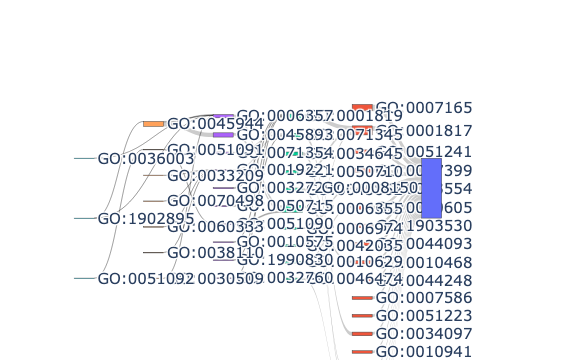

In [173]:
tmp = plot_sankey(sankey_value_id, sankey_source_id, sankey_target_id,
                node_label, back_tracing_color, back_tracing_level, # node_level, 
                x_loc_by_level=True)

In [165]:
np.where(sankey_target == node_label_id['GO:0060333'])

(array([], dtype=int64),)

In [137]:
sankey_value[sankey_target == node_label_id['GO:1903530'],12]

array([-1.53212093e-04,  9.67462012e-05,  5.76047434e-04,  2.25046678e-03])

### At disease level

In [25]:
test_data, test_labels = testing_set[0:]
labels_str = [idx_2_cancer[idx.item()] for idx in test_labels]
data_ov, labels_ov = testing_set[np.nonzero(np.array(labels_str) == 'OV')[0].tolist()]

data_brca, labels_brca = testing_set[np.nonzero(np.array(labels_str) == 'BRCA')[0].tolist()]

In [26]:
(inputdata, labels) = testing_set[:220]
inputdata = torch.cat((inputdata, data_ov))
labels = torch.cat((labels, labels_ov))

inputdata = torch.cat((inputdata, data_brca[-60:]))
labels = torch.cat((labels, labels_brca[-60:]))

labels_str = [idx_2_cancer[idx.item()] for idx in labels]
list(zip(*np.unique(labels_str, return_counts=True)))

[('ACC', 2),
 ('BLCA', 12),
 ('BRCA', 82),
 ('CESC', 10),
 ('CHOL', 1),
 ('COAD', 15),
 ('DLBC', 1),
 ('ESCA', 1),
 ('GBM', 3),
 ('HNSC', 10),
 ('KICH', 1),
 ('KIRC', 10),
 ('KIRP', 5),
 ('LAML', 3),
 ('LGG', 14),
 ('LIHC', 4),
 ('LUAD', 16),
 ('LUSC', 3),
 ('OV', 89),
 ('PAAD', 5),
 ('PCPG', 5),
 ('PRAD', 8),
 ('READ', 4),
 ('SARC', 10),
 ('SKCM', 9),
 ('STAD', 7),
 ('TGCT', 1),
 ('THCA', 9),
 ('THYM', 3),
 ('UCEC', 16),
 ('UVM', 4)]

In [27]:
torch.manual_seed(0)
logits = model(inputdata.to(DEVICE))

In [28]:
pred_res = torch.argmax(logits, 1).cpu() == labels
torch.sum(pred_res)/len(labels)

tensor(0.8678)

In [29]:
accu_per_type = {}

for cancer_type in range(33):
    accu_per_type[idx_2_cancer[cancer_type]] = (pred_res[labels == cancer_type]).float().mean().item()

accu_per_type

{'BRCA': 0.9268292784690857,
 'LUAD': 0.5625,
 'DLBC': 0.0,
 'UCEC': 0.9375,
 'SKCM': 0.8888888955116272,
 'PRAD': 1.0,
 'HNSC': 1.0,
 'KIRP': 0.6000000238418579,
 'CESC': 0.0,
 'THCA': 1.0,
 'KIRC': 1.0,
 'STAD': 1.0,
 'COAD': 0.800000011920929,
 'READ': 0.0,
 'LGG': 1.0,
 'MESO': nan,
 'LAML': 1.0,
 'BLCA': 0.8333333134651184,
 'OV': 0.9775280952453613,
 'LUSC': 1.0,
 'ACC': 0.0,
 'THYM': 0.6666666865348816,
 'ESCA': 1.0,
 'PAAD': 1.0,
 'LIHC': 1.0,
 'SARC': 1.0,
 'GBM': 1.0,
 'TGCT': 1.0,
 'KICH': 0.0,
 'PCPG': 1.0,
 'UCS': nan,
 'UVM': 0.0,
 'CHOL': 0.0}

In [30]:
torch.manual_seed(0)

sankey_value, sankey_source, sankey_target, \
        node_label_id, node_label, node_col, node_level\
                = prepare_node_edge(model, inputdata, target=labels.to(DEVICE))

/homes/ac.tfeng/miniconda3/envs/general/lib/python3.9/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(
Level1: 357it [00:00, 3343.34it/s]
Level2: 183it [00:00, 2740.40it/s]
Level3: 115it [00:00, 2060.04it/s]
Level4: 66it [00:00, 2214.54it/s]
Level5: 1it [00:00, 57.71it/s]


In [30]:
sankey_value[:, labels == 18].shape

(3167, 89)

In [31]:
node_label[2068]

'GO:0009725'

In [32]:
sankey_source[2984]

2068

In [33]:
sankey_target[2984]

2090

In [34]:
node_label[2090]

'GO:0008150'

In [35]:
sankey_value[2984,:].mean()

0.008377317976495435

In [36]:
cancer_2_idx['OV']

18

In [37]:
sankey_value_id_ov, sankey_source_id_ov, sankey_target_id_ov\
    = sankey_trimming(sankey_value[:, labels == cancer_2_idx['OV']].mean(axis=1, keepdims=True), 
                      sankey_source, sankey_target, 
                    node_label_id, 
                    sample_id = 0, 
                    percent_keep = [0.04, 0.1, 0.15, 0.3, 0.5])

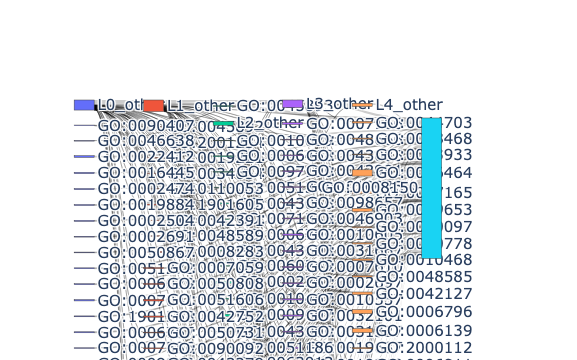

In [38]:
ov_sankey = plot_sankey(sankey_value_id_ov, sankey_source_id_ov, sankey_target_id_ov,
                node_label, node_col, node_level, positive_flow=True, go_dag=go_dag, filename='Sankey_OV')

In [53]:
sankey_value_id_brca, sankey_source_id_brca, sankey_target_id_brca\
    = sankey_trimming(sankey_value[:, labels == cancer_2_idx['BRCA']].mean(axis=1, keepdims=True), 
                      sankey_source, sankey_target, 
                    node_label_id, 
                    sample_id = 0, 
                    percent_keep = [0.04, 0.1, 0.15, 0.3, 0.5])  # [0.015, 0.05, 0.075, 0.09, 0.17]

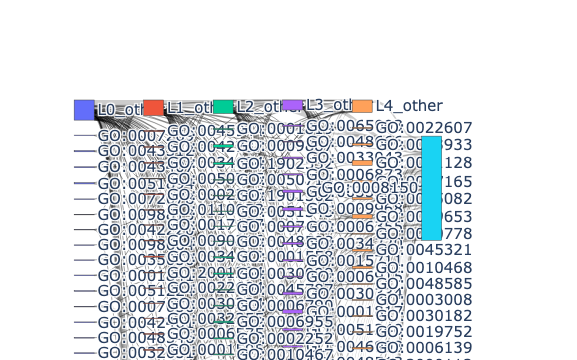

In [54]:
brca_sankey = plot_sankey(sankey_value_id_brca, sankey_source_id_brca, sankey_target_id_brca,
                node_label, node_col, node_level, positive_flow=True, go_dag=go_dag, filename='Sankey_BRCA')

In [42]:
np.array(node_label)[sankey_source]

array(['GO:0007006', 'GO:0008637', 'GO:0006284', ..., 'GO:1901985',
       'GO:1902003', 'GO:1902036'], dtype='<U10')

In [40]:
def go_name_converter(labellist, go_dag):
    fullname_list = []
    for node_label_tmp in labellist:
        if node_label_tmp in go_dag:
            fullname_list.append(go_dag[node_label_tmp].name)
        else:
            fullname_list.append(node_label_tmp)
    
    return fullname_list

In [41]:
import pandas as pd
path_importance = pd.DataFrame({'source': np.array(node_label)[sankey_source],
                                'target': np.array(node_label)[sankey_target],
                                'imp_score_ov': sankey_value[:, labels == cancer_2_idx['OV']].mean(axis=1, keepdims=False),
                                'imp_score_brca': sankey_value[:, labels == cancer_2_idx['BRCA']].mean(axis=1, keepdims=False),
                               'source_full_name': go_name_converter(np.array(node_label)[sankey_source], go_dag),
                               'target_full_name': go_name_converter(np.array(node_label)[sankey_target], go_dag)})
path_importance.to_csv("path_importance.csv")

#### Tracing version of the plots

In [39]:
sankey_value_tracing_ov, sankey_source_tracing_ov, sankey_target_tracing_ov, back_tracing_level_tracing_ov, back_tracing_color_tracing_ov \
    = sankey_backward_trace(sankey_value[:, labels == cancer_2_idx['OV']].mean(axis=1, keepdims=True), 
                            sankey_source, sankey_target, 
                            node_label_id,
                            sample_id=0, 
                            percent_keep = 0.05, min_num=10)

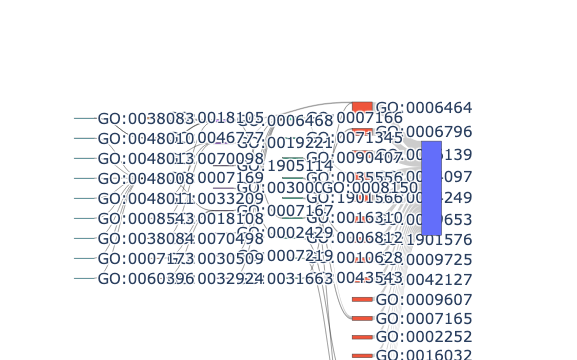

In [40]:
ov_sankey = plot_sankey(sankey_value_tracing_ov, sankey_source_tracing_ov, sankey_target_tracing_ov,
                node_label, back_tracing_color_tracing_ov, back_tracing_level_tracing_ov, positive_flow=True, go_dag=go_dag, 
                filename='Sankey_Tracing_OV')

In [39]:
sankey_value_tracing_ov, sankey_source_tracing_ov, sankey_target_tracing_ov, back_tracing_level_tracing_ov, back_tracing_color_tracing_ov \
    = sankey_backward_trace(sankey_value[:, labels == cancer_2_idx['OV']].mean(axis=1, keepdims=True), 
                            sankey_source, sankey_target, 
                            node_label_id,
                            sample_id=0, 
                            percent_keep = 0.05, min_num=10)

In [41]:
sankey_value_tracing_brca, sankey_source_tracing_brca, sankey_target_tracing_brca, back_tracing_level_tracing_brca, back_tracing_color_tracing_brca \
    = sankey_backward_trace(sankey_value[:, labels == cancer_2_idx['BRCA']].mean(axis=1, keepdims=True), 
                            sankey_source, sankey_target, 
                            node_label_id,
                            sample_id=0, 
                            percent_keep = 0.05, min_num=10)

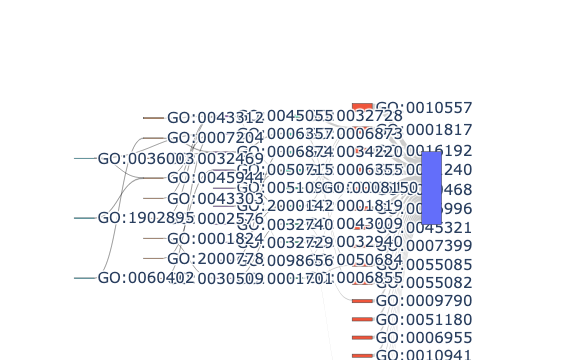

In [148]:
brca_sankey = plot_sankey(sankey_value_tracing_brca, sankey_source_tracing_brca, sankey_target_tracing_brca,
                node_label, back_tracing_color_tracing_brca, back_tracing_level_tracing_brca, positive_flow=True, go_dag=go_dag, 
                filename='Sankey_Tracing_BRCA')

### For L0 level importance

In [31]:
test_data, test_labels = testing_set[0:]
labels_str = [idx_2_cancer[idx.item()] for idx in test_labels]
data_ov, labels_ov = testing_set[np.nonzero(np.array(labels_str) == 'OV')[0].tolist()]

data_brca, labels_brca = testing_set[np.nonzero(np.array(labels_str) == 'BRCA')[0].tolist()]

In [32]:
torch.manual_seed(0)

(inputdata, labels) = testing_set[:220]
inputdata = torch.cat((inputdata, data_ov))
labels = torch.cat((labels, labels_ov))

inputdata = torch.cat((inputdata, data_brca[-60:]))
labels = torch.cat((labels, labels_brca[-60:]))

labels_str = [idx_2_cancer[idx.item()] for idx in labels]

term_list = []
leaves = model.term_layer_list[0]
for idx_leaf, term in enumerate(leaves):
    term_list.append(model._modules[term+'_linear_layer'])
layer0_ig = LayerIntegratedGradients(model, term_list)

layer0_attr_list = layer0_ig.attribute(inputdata.to(DEVICE), target=labels.to(DEVICE),
                                      attribute_to_layer_input=False)

In [33]:
layer0_attr_stack = torch.stack(layer0_attr_list, dim=0)

In [34]:
layer0_attr_stack.shape


torch.Size([1364, 363, 6])

In [35]:
layer0_attr = layer0_attr_stack.mean(dim=2)

In [36]:
layer0_ov_attr = layer0_attr[:, labels == cancer_2_idx['OV']].mean(1)
layer0_brca_attr = layer0_attr[:, labels == cancer_2_idx['BRCA']].mean(1)


In [42]:
layer0_ov_attr

tensor([-5.1750e-04, -5.0931e-05, -3.3807e-05,  ..., -1.0903e-04,
        -1.7710e-04,  1.6560e-04], device='cuda:6', dtype=torch.float64)

In [44]:
l0_node_importance = pd.DataFrame({'terms': leaves,
              'terms_full_name': go_name_converter(leaves, go_dag),
              'imp_ov': layer0_ov_attr.cpu(),
              'imp_brca': layer0_brca_attr.cpu()})
l0_node_importance.to_csv('L0_node_importance.csv')

In [108]:
np.flip(np.array(leaves)[torch.argsort(layer0_ov_attr.cpu(), descending=True)][:20])

array(['GO:0022037', 'GO:0051145', 'GO:0009651', 'GO:0030104',
       'GO:0072078', 'GO:0045745', 'GO:0010906', 'GO:0009812',
       'GO:0010885', 'GO:0090312', 'GO:0071243', 'GO:2001056',
       'GO:0006413', 'GO:0022617', 'GO:0010453', 'GO:0032330',
       'GO:0035108', 'GO:0048705', 'GO:0150063', 'GO:0006595'],
      dtype='<U10')

In [109]:
def go_name_converter(labellist, go_dag):
    fullname_list = []
    for node_label_tmp in labellist:
        if node_label_tmp in go_dag:
            fullname_list.append(go_dag[node_label_tmp].name)
        else:
            fullname_list.append(node_label_tmp)
    
    return fullname_list

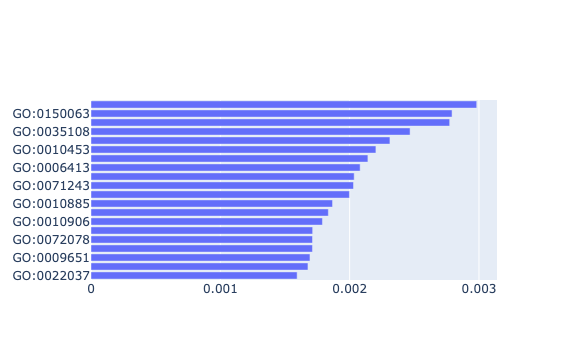

In [110]:
labels_ov = np.flip(np.array(leaves)[torch.argsort(layer0_ov_attr.cpu(), descending=True)][:20])

sankey_node_fullname_ov = go_name_converter(labels_ov, go_dag)

fig = go.Figure(go.Bar(
            x=layer0_ov_attr[torch.argsort(layer0_ov_attr.cpu(), descending=True)][:20].cpu().flip(0),
            y=labels_ov,
            customdata=sankey_node_fullname_ov,
            hovertemplate = "%{y}: %{customdata}<extra></extra>",
            orientation='h'))

fig.write_html("OV_barplot_level0.html")
fig.show()

In [111]:
layer0_brca_attr[torch.argsort(layer0_brca_attr.cpu(), descending=True)][:20].cpu().flip(0).shape

torch.Size([20])

In [112]:
labels_brca.shape

torch.Size([332])

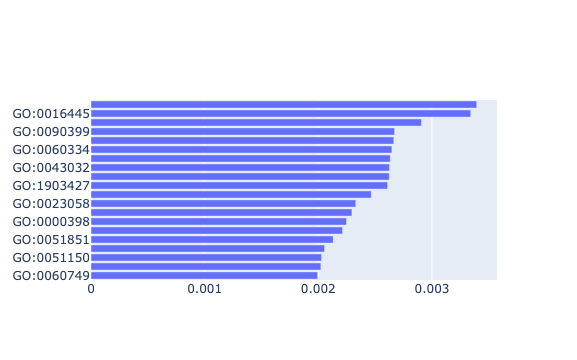

In [113]:
labels_brca = np.flip(np.array(leaves)[torch.argsort(layer0_brca_attr.cpu(), descending=True)][:20])

sankey_node_fullname_brca = go_name_converter(labels_brca, go_dag)

fig = go.Figure(go.Bar(
            x=layer0_brca_attr[torch.argsort(layer0_brca_attr.cpu(), descending=True)][:20].cpu().flip(0),
            y=labels_brca,
            customdata=sankey_node_fullname_brca,
            hovertemplate = "%{y}: %{customdata}<extra></extra>",
            orientation='h'))

fig.write_html("BRCA_barplot_level0.html")
fig.show()

### Pair ranking

In [139]:
full_name_source

['mitochondrial membrane organization',
 'apoptotic mitochondrial changes',
 'base-excision repair',
 'transcription-coupled nucleotide-excision repair',
 'translesion synthesis',
 'double-strand break repair via homologous recombination',
 'double-strand break repair via nonhomologous end joining',
 'positive regulation of DNA repair',
 'long-chain fatty acid biosynthetic process',
 'linoleic acid metabolic process',
 'cyclooxygenase pathway',
 'epoxygenase P450 pathway',
 'iron ion transport',
 'ciliary basal body-plasma membrane docking',
 'mitotic spindle assembly',
 'phosphatidylcholine biosynthetic process',
 'amine biosynthetic process',
 'tetrapyrrole biosynthetic process',
 'cellular modified amino acid biosynthetic process',
 'catecholamine biosynthetic process',
 'peptide biosynthetic process',
 'nucleobase biosynthetic process',
 'pyridine-containing compound biosynthetic process',
 'glutathione derivative biosynthetic process',
 'ceramide biosynthetic process',
 'protein l

In [132]:
import itertools

full_name_source = go_name_converter(np.array(node_label)[sankey_source], go_dag)
full_name_target = go_name_converter(np.array(node_label)[sankey_target], go_dag)
                                                           
list_pairs = np.array([a+'_'+b for a, b in zip(np.array(node_label)[sankey_source], 
                                            np.array(node_label)[sankey_target])])

In [134]:
np.flip(list_pairs[pair_indices[:20]])

array(['GO:1901796_GO:0008150', 'GO:0044703_GO:0008150',
       'GO:0019637_GO:0008150', 'GO:0010468_GO:0008150',
       'GO:0022412_GO:0008150', 'GO:0006811_GO:0008150',
       'GO:0016192_GO:0008150', 'GO:0016032_GO:0008150',
       'GO:0002252_GO:0008150', 'GO:0007165_GO:0008150',
       'GO:0009607_GO:0008150', 'GO:0042127_GO:0008150',
       'GO:0009725_GO:0008150', 'GO:1901576_GO:0008150',
       'GO:0009653_GO:0008150', 'GO:0044249_GO:0008150',
       'GO:0034097_GO:0008150', 'GO:0006139_GO:0008150',
       'GO:0006796_GO:0008150', 'GO:0006464_GO:0008150'], dtype='<U21')

In [144]:
([np.flip(np.array(full_name_source)[pair_indices[:20]]), 
                        np.flip(np.array(full_name_target)[pair_indices[:20]])][0])

array(['regulation of signal transduction by p53 class mediator',
       'multi-organism reproductive process',
       'organophosphate metabolic process',
       'regulation of gene expression',
       'cellular process involved in reproduction in multicellular organism',
       'monoatomic ion transport', 'vesicle-mediated transport',
       'viral process', 'immune effector process', 'signal transduction',
       'response to biotic stimulus',
       'regulation of cell population proliferation',
       'response to hormone', 'organic substance biosynthetic process',
       'anatomical structure morphogenesis',
       'cellular biosynthetic process', 'response to cytokine',
       'nucleobase-containing compound metabolic process',
       'phosphate-containing compound metabolic process',
       'protein modification process'], dtype='<U144')

In [146]:
np.dstack((np.flip(np.array(full_name_source)[pair_indices[:20]]), 
                                  np.flip(np.array(full_name_target)[pair_indices[:20]])))

array([[['regulation of signal transduction by p53 class mediator',
         'biological_process'],
        ['multi-organism reproductive process', 'biological_process'],
        ['organophosphate metabolic process', 'biological_process'],
        ['regulation of gene expression', 'biological_process'],
        ['cellular process involved in reproduction in multicellular organism',
         'biological_process'],
        ['monoatomic ion transport', 'biological_process'],
        ['vesicle-mediated transport', 'biological_process'],
        ['viral process', 'biological_process'],
        ['immune effector process', 'biological_process'],
        ['signal transduction', 'biological_process'],
        ['response to biotic stimulus', 'biological_process'],
        ['regulation of cell population proliferation',
         'biological_process'],
        ['response to hormone', 'biological_process'],
        ['organic substance biosynthetic process', 'biological_process'],
        ['anatomic

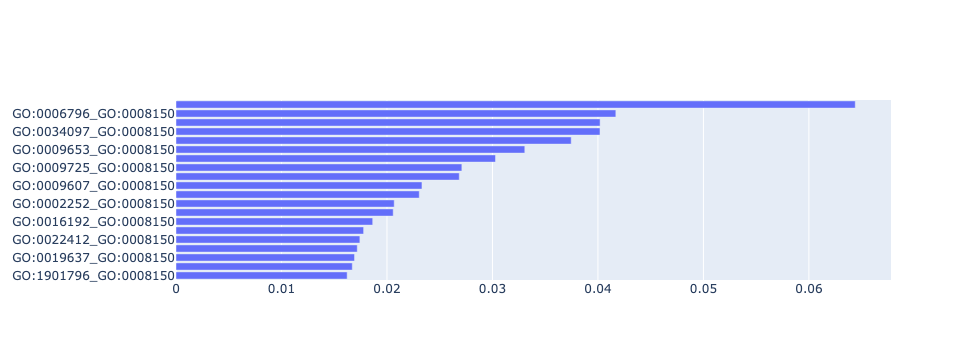

In [147]:
avg_ov_values = sankey_value[:, labels == cancer_2_idx['OV']].mean(axis=1)
pair_indices = np.argsort(-avg_ov_values)

fig = go.Figure(go.Bar(
            x=np.flip(avg_ov_values[pair_indices[:20]]),
            y=np.flip(list_pairs[pair_indices[:20]]),
            customdata=np.dstack((np.flip(np.array(full_name_source)[pair_indices[:20]]), 
                                  np.flip(np.array(full_name_target)[pair_indices[:20]])))[0],
            hovertemplate = "From %{customdata[0]} <br>" + "To %{customdata[1]}",
            orientation='h'))
fig.show()

In [116]:
list_pairs[pair_indices[:20]]

array(['GO:0007006_GO:0008150', 'GO:0007006_GO:0008150',
       'GO:0007006_GO:0008150', 'GO:0007006_GO:0008150',
       'GO:0007006_GO:0008150', 'GO:0007006_GO:0008150',
       'GO:0007006_GO:0008150', 'GO:0007006_GO:0008150',
       'GO:0007006_GO:0008150', 'GO:0007006_GO:0008150',
       'GO:0007006_GO:0008150', 'GO:0007006_GO:0008150',
       'GO:0007006_GO:0008150', 'GO:0007006_GO:0008150',
       'GO:0007006_GO:0008150', 'GO:0007006_GO:0008150',
       'GO:0007006_GO:0008150', 'GO:0007006_GO:0008150',
       'GO:0007006_GO:0008150', 'GO:0007006_GO:0008150'], dtype='<U21')

In [219]:
labels_brca

array(['GO:0000398', 'GO:1901068', 'GO:0021545', 'GO:0031345',
       'GO:1905269', 'GO:0043576', 'GO:0060334', 'GO:0051150',
       'GO:0045742', 'GO:0032728', 'GO:0043032', 'GO:0023058',
       'GO:0051674', 'GO:0006029', 'GO:0090399', 'GO:1902003',
       'GO:1903427', 'GO:0044257', 'GO:0016445', 'GO:0010888'],
      dtype='<U10')

# GDSC

## Data Loading

In [8]:
### Data loading
training_file = "data/drugcell_train.txt"
testing_file = "data/drugcell_test.txt"
val_file = "data/drugcell_val.txt"
cell2id_file = "data/cell2ind.txt"
drug2id_file = "data/drug2ind.txt"
genotype_file = "data/cell2mutation.txt"
fingerprint_file = "data/drug2fingerprint.txt"
onto_file = "data/drugcell_ont.txt"
gene2id_file = "data/gene2ind.txt"

train_data, feature_dict, cell2id_mapping, drug2id_mapping = prepare_train_data(training_file, 
                                                                  testing_file, cell2id_file, 
                                                                  drug2id_file)

gene2id_mapping = load_mapping(gene2id_file)

# load cell/drug features
cell_features = np.genfromtxt(genotype_file, delimiter=',')
drug_features = np.genfromtxt(fingerprint_file, delimiter=',')

num_cells = len(cell2id_mapping)
num_drugs = len(drug2id_mapping)
num_genes = len(gene2id_mapping)
drug_dim = len(drug_features[0,:])

# load ontology
dG, root, term_size_map, \
    term_direct_gene_map = load_ontology(onto_file, 
                                         gene2id_mapping)

Total number of cell lines = 1225
Total number of drugs = 684
There are 3008 genes
There are 1 roots: GO:0008150
There are 2086 terms
There are 1 connected componenets


In [10]:
from typing import List, Union

def set_col_names_in_multilevel_dataframe(
    df: pd.DataFrame,
    level_map: dict,
    gene_system_identifier: Union[str, List[str]]="Gene_Symbol") -> pd.DataFrame:
    """ Util function that supports loading of the omic data files.
    Returns the input dataframe with the multi-level column names renamed as
    specified by the gene_system_identifier arg.

    Args:
        df (pd.DataFrame): omics dataframe
        level_map (dict): encodes the column level and the corresponding identifier systems
        gene_system_identifier (str or list of str): gene identifier system to use
            options: "Entrez", "Gene_Symbol", "Ensembl", "all", or any list
                     combination of ["Entrez", "Gene_Symbol", "Ensembl"]

    Returns:
        pd.DataFrame: the input dataframe with the specified multi-level column names
    """
    df = df.copy()

    level_names = list(level_map.keys())
    level_values = list(level_map.values())
    n_levels = len(level_names)
    
    if isinstance(gene_system_identifier, list) and len(gene_system_identifier) == 1:
        gene_system_identifier = gene_system_identifier[0]

    # print(gene_system_identifier)
    # import pdb; pdb.set_trace()
    if isinstance(gene_system_identifier, str):
        if gene_system_identifier == "all":
            df.columns = df.columns.rename(level_names, level=level_values)  # assign multi-level col names
        else:
            df.columns = df.columns.get_level_values(level_map[gene_system_identifier])  # retian specific column level
    else:
        assert len(gene_system_identifier) <= n_levels, f"'gene_system_identifier' can't contain more than {n_levels} items."
        set_diff = list(set(gene_system_identifier).difference(set(level_names)))
        assert len(set_diff) == 0, f"Passed unknown gene identifiers: {set_diff}"
        kk = {i: level_map[i] for i in level_map if i in gene_system_identifier}
        # print(list(kk.keys()))
        # print(list(kk.values()))
        df.columns = df.columns.rename(list(kk.keys()), level=kk.values())  # assign multi-level col names
        drop_levels = list(set(level_map.values()).difference(set(kk.values())))
        df = df.droplevel(level=drop_levels, axis=1)
    return df


def load_gene_expression_data(gene_expression_file_path, 
    gene_system_identifier: Union[str, List[str]]="Gene_Symbol",
    sep: str="\t",
    verbose: bool=True) -> pd.DataFrame:
    """
    Returns gene expression data.

    Args:
        gene_system_identifier (str or list of str): gene identifier system to use
            options: "Entrez", "Gene_Symbol", "Ensembl", "all", or any list
                     combination of ["Entrez", "Gene_Symbol", "Ensembl"]

    Returns:
        pd.DataFrame: dataframe with the omic data
    """
    # level_map encodes the relationship btw the column and gene identifier system
    level_map = {"Ensembl": 0, "Entrez": 1, "Gene_Symbol": 2}
    header = [i for i in range(len(level_map))]

    df = pd.read_csv(gene_expression_file_path, sep=sep, index_col=0, header=header)

    df.index.name = "improve_sample_id"  # assign index name
    df = set_col_names_in_multilevel_dataframe(df, level_map, gene_system_identifier)
    if verbose:
        print(f"Gene expression data: {df.shape}")
    return df

gene_express = load_gene_expression_data("data/GDSC/cancer_gene_expression.tsv")
response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')
gdsc_info = pd.read_csv("data/GDSC/GDSC_info.csv")
gdsc = pd.merge(gene_express, gdsc_info, how="inner", left_on=["improve_sample_id"], right_on=['ModelID'])
gdsc_x = gdsc.loc[:, gene_express.columns]
gdsc_y = gdsc.loc[:, 'DepmapModelType']

Gene expression data: (1007, 30805)


/tmp/ipykernel_468075/3534681654.py:78: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')


In [11]:
gene_intersect_list = list(set(gene2id_mapping.keys()) & set(gdsc_x.columns))
gdsc_tensor = torch.zeros(gdsc_x.shape[0], num_genes)

for gene in gene_intersect_list:
    idx = gene2id_mapping[gene]
    gdsc_tensor[:,idx] = torch.tensor(gdsc_x[gene])

cancer_2_idx = {}
idx_2_cancer = {}
cancer_type_idx = []

i = 0
for cancer in gdsc_y:
    if cancer not in cancer_2_idx:
        cancer_2_idx[cancer] = i
        idx_2_cancer[i] = cancer
        cancer_type_idx.append(i)
        
        i += 1
    else:
        cancer_type_idx.append(cancer_2_idx[cancer])

There are 3008 genes
There are 1 roots: GO:0008150
There are 2086 terms
There are 1 connected componenets


In [12]:
drug_info_data = pd.read_csv('data/GDSC/drug_info.tsv', sep='\t')
response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')
response_gdcs2 = response[response['source'] == 'GDSCv2'].loc[:,['improve_sample_id', 
                                                             'improve_chem_id',
                                                         'auc']]

# %%
a = response_gdcs2['improve_chem_id'].value_counts()
# %%
GDSC_drug = drug_info_data[drug_info_data['improve_chem_id'].isin(a.index)]
GDSC_drug = GDSC_drug.loc[GDSC_drug['DrugID'].str.startswith('GDSC')]
# %% With Drug embedding

drug_info_data = pd.read_csv('data/GDSC/drug_info.tsv', sep='\t')
response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')
response_gdcs2 = response[response['source'] == 'GDSCv2'].loc[:,['improve_sample_id', 
                                                             'improve_chem_id',
                                                         'auc']]
gene_express = load_gene_expression_data("data/GDSC/cancer_gene_expression.tsv")
drug_ecfp4_nbits512 = pd.read_csv("data/GDSC/drug_ecfp4_nbits512.tsv", sep = '\t', index_col=0)

gdsc_row_key_id = {k: v for v, k in enumerate(gene_express.index)}
gdsc_row_id_key = {v: k for v, k in enumerate(gene_express.index)}

chem_row_key_id = {k: v for v, k in enumerate(drug_ecfp4_nbits512.index)}
chem_row_id_key = {v: k for v, k in enumerate(drug_ecfp4_nbits512.index)}
# %%
response_gdcs2 = response_gdcs2.replace({'improve_sample_id': gdsc_row_key_id})
response_gdcs2 = response_gdcs2.replace({'improve_chem_id': chem_row_key_id})
response_gdcs2 = torch.tensor(response_gdcs2.to_numpy())

train_gdcs_idx = torch.unique(response_gdcs2[:,0], sorted=False)[:423]
test_gdcs_idx = torch.unique(response_gdcs2[:,0], sorted=False)[423:]

drug_tensor = torch.tensor(drug_ecfp4_nbits512.to_numpy())
#%%
class GDSCData(Dataset):
    
    def __init__(self, response, gene_tensor, chem_tensor):
        self.response = response
        self.gene_tensor = gene_tensor
        self.chem_tensor = chem_tensor
        
    def __len__(self):
        return self.response.shape[0]
    
    def __getitem__(self, index):
        sample = self.response[index,:]
        
        X_gene = self.gene_tensor[sample[0].long() ,:]
        X_chem = self.chem_tensor[sample[1].long() ,:]
        
        y = sample[2]

        X = torch.cat((X_gene, X_chem), 0)
        
        return X, y

gdsc_data = GDSCData(response_gdcs2, gdsc_tensor, drug_tensor)
gdsc_data_train = GDSCData(response_gdcs2[torch.isin(response_gdcs2[:,0], train_gdcs_idx)].float(), gdsc_tensor, drug_tensor)
gdsc_data_test = GDSCData(response_gdcs2[torch.isin(response_gdcs2[:,0], test_gdcs_idx)].float(), gdsc_tensor, drug_tensor)

train_loader = DataLoader(gdsc_data_train,
                          batch_size=len(gdsc_data_train), shuffle=False)
test_loader = DataLoader(gdsc_data_test, 
                         batch_size=len(gdsc_data_test), shuffle=False)

(train_data, train_response) = next(iter(train_loader))
(test_data, test_response) = next(iter(test_loader))

/tmp/ipykernel_468075/3650112765.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')
/tmp/ipykernel_468075/3650112765.py:15: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv("data/GDSC/response.tsv", sep = '\t')


Gene expression data: (1007, 30805)
